/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
✅ Combined XGBoost + GRU MAPE: 1.82%


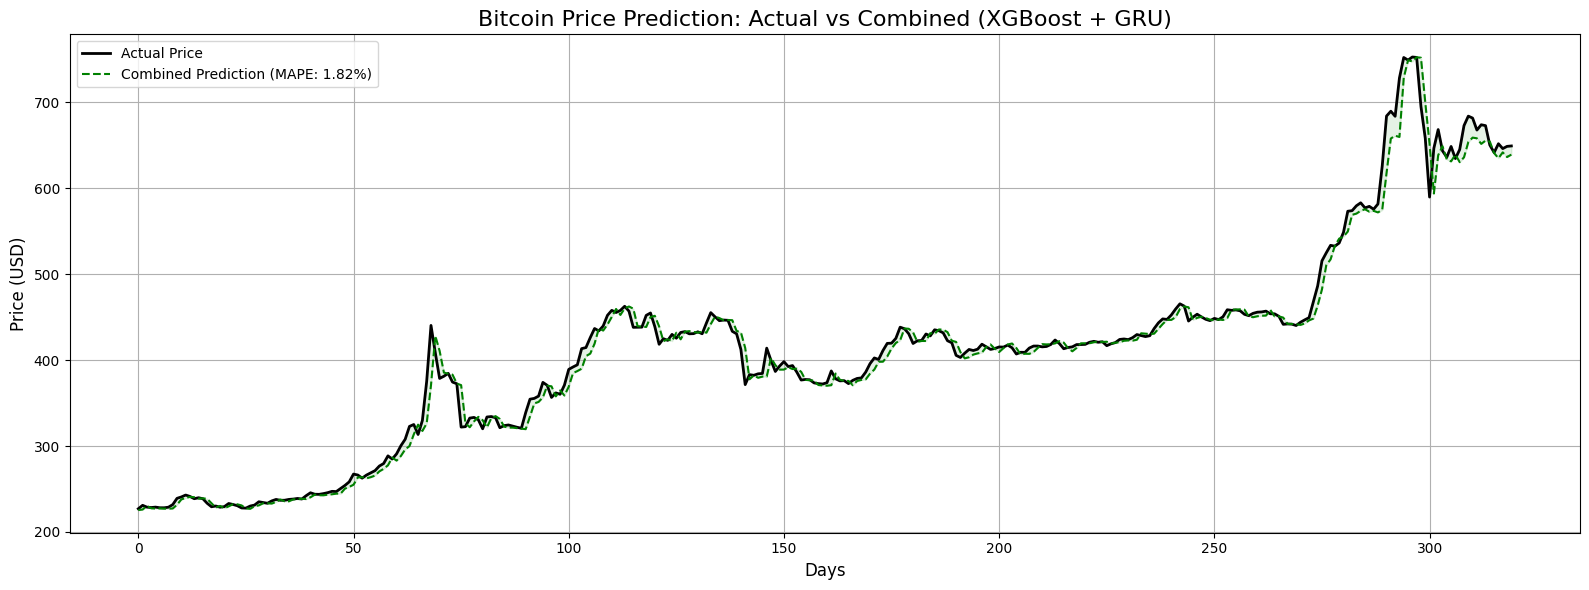

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
df = pd.read_csv('/content/btcusd_1-min_data.csv')
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

if 'Weighted_Price' in df.columns:
    df['Weighted_Price'] = pd.to_numeric(df['Weighted_Price'], errors='coerce')

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df = df.set_index('Date').resample('D')[numeric_cols].mean().ffill()

# Feature engineering
df['Price_Range'] = df['High'] - df['Low']
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df = df.dropna()

# Prepare data
sequence_length = 30
target_col = 'Close'

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0.1, 0.9))  # Stable range for better gradients
scaled_data = scaler.fit_transform(df[[target_col]])
X, y = create_sequences(scaled_data, sequence_length)

# Temporal split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=6,
    subsample=0.95,
    colsample_bytree=0.85,
    gamma=0.05,
    reg_alpha=0.2,
    reg_lambda=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = xgb_model.predict(X_test_xgb)

# GRU model
gru_model = Sequential([
    GRU(160, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.1),
    GRU(80),
    Dropout(0.05),
    Dense(40, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)
gru_pred = gru_model.predict(X_test)

# Inverse transform
def inverse_transform(data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

y_test_actual = inverse_transform(y_test)
xgb_pred_actual = inverse_transform(xgb_pred)
gru_pred_actual = inverse_transform(gru_pred)

# Ensemble prediction
combined_pred_actual = (xgb_pred_actual + gru_pred_actual) / 2

# MAPE
def calculate_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape_combined = calculate_mape(y_test_actual, combined_pred_actual)
print(f"✅ Combined XGBoost + GRU MAPE: {mape_combined:.2f}%")

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(y_test_actual, label='Actual Price', color='black', linewidth=2)
plt.plot(combined_pred_actual, label=f'Combined Prediction (MAPE: {mape_combined:.2f}%)', color='green', linestyle='--')
plt.fill_between(range(len(y_test_actual)), y_test_actual, combined_pred_actual, color='green', alpha=0.1)
plt.title('Bitcoin Price Prediction: Actual vs Combined (XGBoost + GRU)', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
